In [1]:
import os
import json
import logging
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import (
    preprocess_data, 
    SequenceDataset, 
    score_model, 
    predict,
    get_predictions,
    plot_predictions)

In [2]:
saved_model_file = "models/LSTM_32unit_1layer_30seq.pt"
model = torch.load(saved_model_file)
model

LSTMRegression(
  (lstm): LSTM(704, 32, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=32, out_features=704, bias=True)
)

In [3]:
filename = "../data/mta_subway_221231_100wk_dbscan.parquet"
df = pd.read_parquet(filename)
df = df.fillna(0)
df.shape

(16800, 704)

In [4]:
df_train, df_test, features = preprocess_data(df)
df_test.shape

(3360, 704)

In [5]:
test_dataset = SequenceDataset(
        df_test,
        #target=None,
        features=features,
        sequence_length=30,
        forecast_lead=1
        )

In [6]:
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [7]:
loss_function = nn.MSELoss()
test_score = score_model(test_loader, model, loss_function)  
test_score

0.4372443149642398

In [8]:
def unnormalize(df):
    feat_stats = json.load(open("location_means_stds.json","rb"))
    mean_keys = [x for x in feat_stats if x[-5:] == '_mean']
    means = {x[:-5]:y for x, y in zip(mean_keys, [feat_stats[x] for x in mean_keys])}

    std_keys = [x for x in feat_stats if x[-4:] == '_std']
    stds = {x[:-4]:y for x, y in zip(std_keys, [feat_stats[x] for x in std_keys])}
    
    for x in df:
        df[x] = (df[x] * stds[x]) + means[x]
    
    return df

In [9]:
def get_predictions(data_loader, model, features):
    y_pred = predict(data_loader, model)
    df_out = pd.DataFrame(y_pred,columns=features)
    # need to rescale prediction values
    df_out = unnormalize(df_out)
    # need to add hour timestamp index for each row
    return df_out

df_out = get_predictions(test_loader, model, features)
df_out.head()

,1 AV_ent,1 AV_ex,103 ST-CORONA_ent,103 ST-CORONA_ex,103 ST_ent,103 ST_ex,104 ST_ent,104 ST_ex,110 ST_ent,110 ST_ex,...,WOODLAWN_ent,WOODLAWN_ex,WORLD TRADE CTR_ent,WORLD TRADE CTR_ex,WTC-CORTLANDT_ent,WTC-CORTLANDT_ex,YORK ST_ent,YORK ST_ex,ZEREGA AV_ent,ZEREGA AV_ex
0,258.423309,426.853271,76.468933,570.452881,335.823639,403.714050,-5.424156,64.834167,86.428864,183.950027,...,63.610538,50.168922,185.215134,149.497803,129.111664,161.657883,145.212158,84.550186,15.341621,50.732063
1,136.505081,239.743286,96.551514,322.715637,96.975159,204.314453,11.309044,28.417353,38.647614,113.617447,...,51.804070,31.366194,48.753098,51.958252,34.158600,53.748734,38.383377,48.885948,1.294224,23.867067
2,149.812195,244.003540,93.972961,293.342316,98.128204,181.377563,16.323704,30.080112,62.765411,98.218155,...,55.429253,26.702137,63.554047,89.103851,15.033257,73.093010,42.413055,27.287521,7.200085,27.014112
3,108.446396,245.741394,136.623260,248.236206,77.834320,159.614990,25.717381,22.278782,56.178482,90.625305,...,56.865547,25.938768,42.291718,81.206100,11.429947,69.628838,24.996704,37.598053,8.200428,20.653603
4,92.402313,267.370697,186.021088,226.624634,71.870422,170.787201,37.590508,18.033474,55.247551,90.773804,...,59.881451,25.849615,34.090347,79.842377,10.416718,60.206818,17.574287,47.284973,9.058506,17.184601


In [10]:
y_true = unnormalize(df_test)
y_true = y_true.iloc[:-1,:]

In [11]:
df_out.index = y_true.index

<AxesSubplot: xlabel='TIME'>

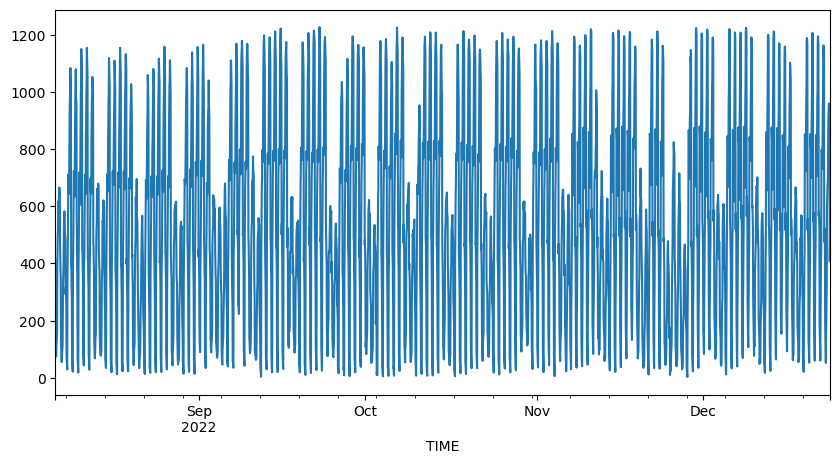

In [12]:
df_out['7 AV_ent'].plot(figsize=(10,5))

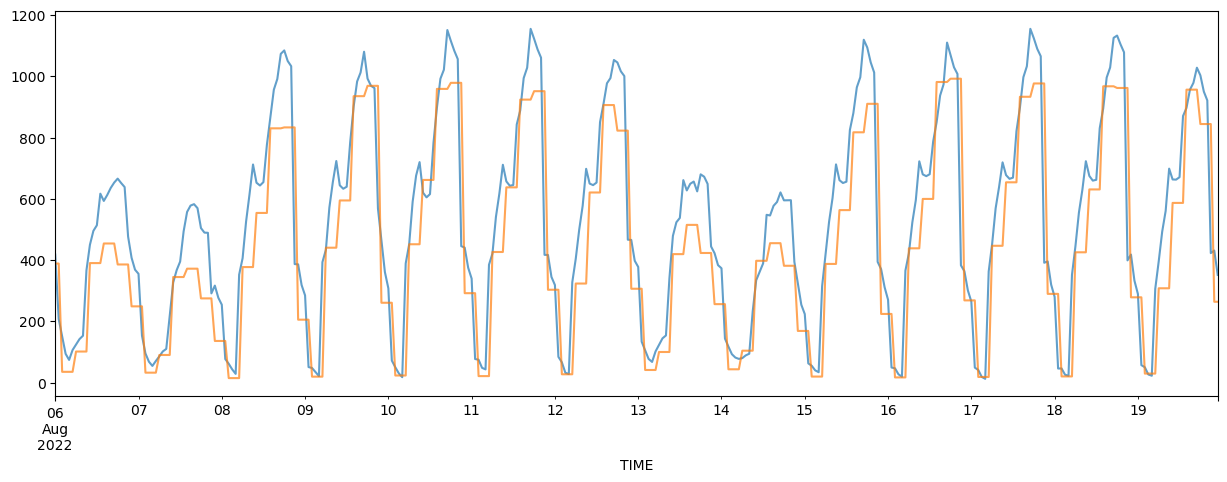

In [13]:
def plot_predictions(y_pred,y_true,station='7 AV'):
    ent = f"{station}_ent"
    ex = f"{station}_ex"
    y_pred[ent].head(336).plot(alpha=0.7,figsize=(15,5))
    y_true[ent].head(336).plot(alpha=0.7,figsize=(15,5))
    plt.show()

plot_predictions(df_out, y_true)

## Notes
- Currently, model just makes one sample prediction based on actual values obtained from training or test dataset. Need to set up to make stepwise prediction for an entire week following prior two weeks as model input. 
    - This can be used for model inference
    - Will give model scores more accurate to what would be used in inference as each sample prediction will be based on prior predicted samples, not actual values as given in training dataset